In [42]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from mave_calibration import main
from joblib import Parallel, delayed
import sys
sys.path.append("/home/dzeiberg")
from mave_results.utils import threshold_utils
from mave_results.utils import skewnorm as skewnorm_utils

In [33]:
true_params = dict(
    fD = ss.skewnorm(a=-2.35217102,
                    loc=-1.55031695,
                    scale=0.77525406),
    fN = ss.skewnorm(a=-0.93037852,
                    loc=0.12707752,
                    scale=0.39826615),
    W = np.array([[0.75, 0.25],
                [0.15, 0.85],]),
    prior = 0.12)

In [34]:
from copy import deepcopy
def sample_data(params, sample_sizes, label_noise=0.0):
    fD = params['fD']
    fN = params['fN']
    wPathogenic, wBenign = params['W']
    prior = params['prior']
    nAbnormalUnlPath, nNormalUnlPath, nAbnormalUnlBen, nNormalUnlBen = np.round(sample_sizes[-1] * np.array([prior * wPathogenic[0],
                                    prior * wPathogenic[1],
                                    (1-prior) * wBenign[0],
                                    (1-prior) * wBenign[1]])).astype(int)
    nAbnormalPath, nNormalPath, nAbnormalBen, nNormalBen = np.round(np.concatenate((sample_sizes[0] * wPathogenic,
                                                                                    sample_sizes[1] * wBenign))).astype(int)
    observations = np.concatenate([
        fD.rvs(nAbnormalPath), fN.rvs(nNormalPath), fD.rvs(nAbnormalBen), fN.rvs(nNormalBen),
        fD.rvs(nAbnormalUnlPath), fN.rvs(nNormalUnlPath), fD.rvs(nAbnormalUnlBen), fN.rvs(nNormalUnlBen)])
    cleanPathogenicityLabels = [np.ones(nAbnormalPath,dtype=int), np.ones(nNormalPath,dtype=int),
                                np.zeros(nAbnormalBen,dtype=int), np.zeros(nNormalBen,dtype=int),
                                np.concatenate((np.ones(nAbnormalUnlPath + nNormalUnlPath,dtype=int),
                                np.zeros(nAbnormalUnlBen + nNormalUnlBen,dtype=int)))]
    pathogenicityLabels = deepcopy(cleanPathogenicityLabels)
    if label_noise > 0:
        # Flip labels for (100 * label_noise)% of the pathogenic functionally normal variants and functionally abnormal benign variants
        pathogenicityLabels[1] = np.random.binomial(1, 1-label_noise, len(pathogenicityLabels[1]))
        pathogenicityLabels[2] = np.random.binomial(1, label_noise, len(pathogenicityLabels[2]))
    
    sampleNumbers = np.concatenate([1 - pathogenicityLabels[0], 1 - pathogenicityLabels[1],
                                    1 - pathogenicityLabels[2], 1 - pathogenicityLabels[3],
                                    np.ones(sample_sizes[2],dtype=int)*2])
    pathogenicityLabels = np.concatenate(pathogenicityLabels)
    
    sampleIndicators = np.zeros((len(observations), len(sample_sizes)),dtype=int)
    sampleIndicators[np.arange(len(observations)), sampleNumbers] = 1
    return observations, sampleIndicators, pathogenicityLabels, np.concatenate(cleanPathogenicityLabels)


In [35]:
X,S,YTilde, Y = sample_data(true_params, [1000,1000,1000],label_noise=0.75)
rng = np.arange(min(X)-.1,max(X)+.1,0.01)

pStar, bStar, priorsStar,_, _, _,log_lrPlusStar, _ = threshold_utils.get_score_threshold(sorted(X),[dict(component_params=[
    [true_params['fD'].kwds['a'], true_params['fD'].kwds['loc'], true_params['fD'].kwds['scale']],
    [true_params['fN'].kwds['a'], true_params['fN'].kwds['loc'], true_params['fN'].kwds['scale']]],
    weights=np.concatenate((true_params['W'],
                            (true_params['W'][0] * true_params['prior'] + \
                                true_params['W'][1] * (1 - true_params['prior'])).reshape((1,-1))))),],
                                parallel=False)

1it [00:01,  1.85s/it]

apply prior requirement



/home/dzeiberg/miniconda3/envs/mave/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


In [37]:
from tqdm.autonotebook import trange
def runFitIter(observations, sample_indicators, **kwargs):
    try:
        iter_fit = main.single_fit(observations,sample_indicators,**kwargs)
        return iter_fit, iter_fit['likelihoods'][-1]
    except AssertionError:
        iter_fit = dict(component_params=None, weights=None, likelihoods=[-1 * np.inf])
        return iter_fit, -1 * np.inf

def runFits(observations, sample_indicators,NFITS = 10,
                NBootstraps=100):
    fits = []
    for iteration in trange(NFITS):
        bootstrap_sample_indices = [np.random.choice(np.where(sample_i)[0],
                                                         sample_i.sum(),
                                                         replace=True) for sample_i in sample_indicators.T]
        indices = np.concatenate(bootstrap_sample_indices)
        XB = observations[indices]
        SB = sample_indicators[indices]
        fit_results = Parallel(n_jobs=min(128,NBootstraps),verbose=10)(delayed(runFitIter)(XB,SB) \
                                                                            for i in range(NBootstraps))
        fit_results = sorted(fit_results,key=lambda tup: tup[1],reverse=True)
        fits.append(fit_results[0][0])
    return fits

In [38]:
fits = runFits(X,S,NFITS=1,)

  0%|          | 0/1 [00:00<?, ?it/s]

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
EM Iteration:   3%|▎         | 339/10000 [00:07<02:08, 75.11it/s, likelihood=-6.115525][Parallel(n_jobs=100)]: Done  88 out of 100 | elapsed:    7.6s remaining:    1.0s
[Parallel(n_jobs=100)]: Done 100 out of 100 | elapsed:   13.3s finished                


In [39]:
Pscores, Bscores, priors,is_inverted, P, B,log_lrPlus, number_invalid_priors = threshold_utils.get_score_threshold(sorted(X), fits,parallel=False)

1it [00:01,  1.82s/it]

apply prior requirement


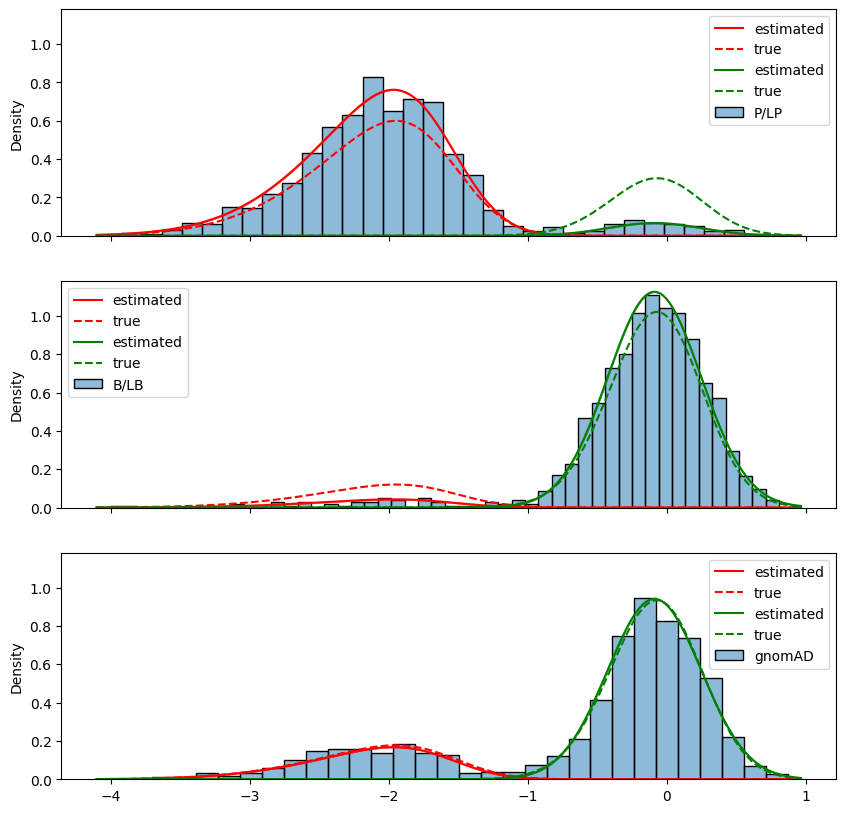

In [44]:
fig,ax = plt.subplots(3,1,figsize=(10,10),sharex=True,sharey=True)
for sampleNum,sampleName in enumerate(["P/LP",'B/LB','gnomAD']):
    sns.histplot(X[S[:,sampleNum]==1],alpha=.5,ax=ax[sampleNum],label=sampleName,stat='density')
    # ax[sampleNum].hist(X[S[:,sampleNum]==1],
    #                     bins=25,
    #                     alpha=0.5,
    #                     label=sampleName,
    #                     density=True)
    ax[sampleNum].legend()
W = np.concatenate((true_params['W'],
                            (true_params['W'][0] * true_params['prior'] + \
                                true_params['W'][1] * (1 - true_params['prior'])).reshape((1,-1))))
fD = true_params['fD']
fN = true_params['fN']
prior = true_params['prior']

thresholds = {("P","true"):{"+1" : pStar[0],
                            "+2" : pStar[1],
                             "+4" : pStar[3],
                             "+8" : pStar[7],},
                             ("B","true"):{"-1" : bStar[0],
                             "-2" : bStar[1],
                             "-4" : bStar[3],
                             "-8" : bStar[7],}}
for sampleNum in range(3):
    joint_densities = np.stack([skewnorm_utils.joint_densities(rng, fit_i['component_params'], fit_i['weights'][sampleNum]) for fit_i in fits])
    
    ax[sampleNum].plot(rng,np.median(joint_densities[:,0,:],axis=0),linestyle='-',color='red',label='estimated')
    ax[sampleNum].fill_between(rng,*np.percentile(joint_densities[:,0,:],[2.5,97.5],axis=0),alpha=0.5,color='red')
    ax[sampleNum].plot(rng, W[sampleNum,0]*fD.pdf(rng),linestyle='--',color='red',label='true')

    ax[sampleNum].plot(rng,np.median(joint_densities[:,1,:],axis=0),linestyle='-',color='green',label='estimated')
    ax[sampleNum].fill_between(rng,*np.percentile(joint_densities[:,1,:],[2.5,97.5],axis=0),alpha=0.5,color='green')
    ax[sampleNum].plot(rng, W[sampleNum,1]*fN.pdf(rng),linestyle='--',color='green',label='true')

[ax[i].legend() for i in range(3)]
thresholds[("P",'estimated')] = {"+1" : Pscores[0],
                            "+2" : Pscores[1],
                             "+4" : Pscores[3],
                             "+8" : Pscores[7],}
thresholds[('B','estimated')]={"-1" : Bscores[0],
                             "-2" : Bscores[1],
                             "-4" : Bscores[3],
                             "-8" : Bscores[7],}
    

In [41]:
pd.DataFrame.from_dict(thresholds,orient='index').sort_index().round(3).fillna("")

+1     +2     +4 +8     -1     -2     -4 -8
B estimated                          -0.94  -0.94 -0.909   
  true                              -0.902 -0.875 -0.774   
P estimated -1.059 -1.059 -1.093                           
  true      -1.093 -1.111 -1.147